In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [3]:
# function for visual feedback
# not necessary for processing

def show(img, title = None):
    '''
    plot an an cv2 image
    '''
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    if title: plt.title(title) 
    plt.show()

def draw_corners(img, corners, name="Corners"):
    '''
    plot an image and numbered points
    used to display corners of YST
    '''
    vis = img.copy()
    for i, (x, y) in enumerate(corners.astype(int)):
        cv2.circle(vis, (x, y), 15, (0, 0, 255), -1)  # red dot
        cv2.putText(vis, str(i), (x+20, y-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 6)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis("off")
    plt.show()

def draw_bounding_boxes(image, rectangles, color=(255, 0, 0), thickness=2):
    '''
    plots and image and the bounding boxes calculated
    '''
    img_copy = image.copy()
    for x, y, w, h in rectangles:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, thickness)
    print(f"{len(rectangles)} bounding boxes found.")
    return img_copy

def yolo_labels_to_rectangles(labels, image_shape):
    '''
    calculate absolute values from yolo labels for checking
    '''
  
    img_h, img_w = image_shape[:2]
    rectangles = []
    
    for label in labels:
        parts = label.strip().split()        
        cls = int(parts[0])                  
        x_c, y_c, w_norm, h_norm = map(float, parts[1:])  
        
        w = int(w_norm * img_w)
        h = int(h_norm * img_h)
        x = int((x_c * img_w) - w / 2)
        y = int((y_c * img_h) - h / 2)
        
        rectangles.append([x, y, w, h])
    
    return rectangles

def check_h_line(bw, h_mid):
    '''
    plots an image with the longest found horizontal line
    '''
    bw_color = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
    x1, y1, x2, y2 = h_mid
    cv2.line(bw_color, (x1, y1), (x2, y2), color=(0,0,255), thickness=10)
    plt.imshow(cv2.cvtColor(bw_color, cv2.COLOR_BGR2RGB))  # convert BGR → RGB
    plt.axis('off')
    plt.show()


In [4]:
#functions for aligning empty image with grid and image with objects to cancel out the grid

def create_binary_mask(image):
    '''
    binary masking with manual set threshold (yellow)
    '''
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask


def find_contour(image):
    ''' 
    find the largest contour, which is the YST
    '''
    mask = create_binary_mask(image)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

def is_upside_orientated(image, contour, v_threshold=50):
    ''' 
    detects the orientation
    upside down image have the letters in the lower half
    more black in the lower half of the YST -> image is upside down
    '''
    
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    V = hsv[:, :, 2]
    black_area = (V < v_threshold)
    black_in_contour = black_area & (mask == 255)

    # Find bounding box of contour, define upper and lower half
    x, y, w, h = cv2.boundingRect(contour)
    upper_half = black_in_contour[y:y+h//2, x:x+w]
    lower_half = black_in_contour[y+h//2:y+h, x:x+w]

    #calculate black and decide
    black_upper = np.sum(upper_half)
    black_lower = np.sum(lower_half)

    if black_upper > black_lower:
        result = True
    elif black_lower > black_upper:
        result = False

    return result

def find_corners(image, contour):
    ''' 
    gets the corners of the YST
    '''
    # Approximate contour to polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2)  # 4 corner points
        return corners
    else:
        print("Not a rectangle detected!")

def order_corners(pts):
    ''' 
    orders the corners for alignment
    '''
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def grow_mask(mask, growth_pixels=5):
    ''' 
    thickens the lines of the grid
    '''

    # Create a square kernel
    kernel_size = 2 * growth_pixels + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Erode the mask to grow black regions
    grown_mask = cv2.erode(mask, kernel, iterations=1)

    return grown_mask

def get_midpoint(mid_h):
    ''' 
    finds the midpoint of a line
    '''
    _, y1, _, y2 = mid_h
    return (y1 + y2) / 2

def get_h_mid(image):
    """
    Find the longest horizontal line in an image
    """

    def horizontal_mid_y(line):
        _, y1, _, y2 = line
        return (y1 + y2) / 2

    def line_length(line):
        x1, y1, x2, y2 = line
        return np.hypot(x2-x1, y2-y1)
    
    # invert so lines become white
    bw = cv2.bitwise_not(image)

    # detect lines
    lines = cv2.HoughLinesP(bw, 1, np.pi/180,
                            threshold=100,
                            minLineLength=1000,
                            maxLineGap=100)

    # filter for horizontal lines
    h_lines = []
    for l in lines:
        x1, y1, x2, y2 = l[0]
        angle = np.degrees(np.arctan2(y2-y1, x2-x1))
        if abs(angle) < 10:  # near horizontal
            h_lines.append((x1, y1, x2, y2))

    # restrict to central band to exclude borders of YST
    H = image.shape[0]
    upper_bound = H * 0.25
    lower_bound = H * 0.75
    h_lines_mid = [l for l in h_lines if upper_bound <= horizontal_mid_y(l) <= lower_bound]

    if not h_lines_mid:
        return None

    # pick longest
    longest = max(h_lines_mid, key=line_length)
    
    return longest

In [5]:
#functions to create bounding boxes and lables

def scale_rect(x, y, w, h, scale):
    """
    Scales a rectangle around its center.
    """
    # Center of original rectangle
    cx = x + w / 2
    cy = y + h / 2

    # New width and height
    new_w = w * scale
    new_h = h * scale

    # New top-left corner
    new_x = cx - new_w / 2
    new_y = cy - new_h / 2

    return int(new_x), int(new_y), int(new_w), int(new_h)

def get_list_of_rectangles(image, min_area, max_area, scale = 2, max_ratio = 2):
    ''' 
        returns a list of bounding boxes for an image (scaled and filtered by "squareness")
        scale: scale factor
        max_ratio: ratio w / h allowed maximally
    '''
    rectangles = []
    
    inverted_mask = cv2.bitwise_not(create_binary_mask(image))  # Invert the mask to get contours on the foreground
    
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        
        if min_area <= contour_area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)
            x,y,w,h = scale_rect(x,y,w,h, scale) #scaling, because the contour misses fine details
            if w == 0 or h == 0:
                continue  # skip invalid rectangles
            ratio = max(w, h) / min(w, h) #calculating ratio to filter out rectangles not "square enough"
            if ratio <= max_ratio:
                rectangles.append([x,y,w,h])
    return rectangles


def pad_image_to_stride(image, tile_size=640, stride=440):
    ''' 
    pad image to allow tiling
    '''
    height, width = image.shape[:2]

    # Calculate how much padding is needed
    pad_bottom = (math.ceil((height - tile_size) / stride) + 1) * stride + tile_size - stride - height
    pad_right  = (math.ceil((width  - tile_size) / stride) + 1) * stride + tile_size - stride - width

    # Apply padding (bottom and right sides only)
    padded_image = cv2.copyMakeBorder(
        image, 0, pad_bottom, 0, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )

    return padded_image

def calculate_intersection_area(tile, rect):
    ''' 
        calculates the intersection of a tile and a rectangle(bounding box) and returns percentage
    '''
    # Calculate the coordinates of the intersection
    x1, y1, w1, h1 = rect
    tx, ty = tile
    x2 = tx + 640
    y2 = ty + 640
    
    # Find the intersection coordinates
    inter_x1 = max(x1, tx)
    inter_y1 = max(y1, ty)
    inter_x2 = min(x1 + w1, x2)
    inter_y2 = min(y1 + h1, y2)

    # Calculate the intersection area
    if inter_x2 > inter_x1 and inter_y2 > inter_y1:
        inter_width = inter_x2 - inter_x1
        inter_height = inter_y2 - inter_y1
        return inter_width * inter_height
    return 0


def check_overlap(tile, rect, overlap_threshold=0.1):
    '''
        checks if the intersection area exceeds a threshold and returns a boolean
    '''
    
    # Calculate the intersection area between the tile and the rectangle
    intersection_area = calculate_intersection_area(tile, rect)
    x, y, w, h = rect
    rect_area = w * h

    # Calculate the overlap percentage
    overlap_percentage = intersection_area / rect_area

    # If the overlap is greater than the threshold, return True
    return overlap_percentage >= overlap_threshold

def get_tiles_with_rectangles(image, rectangles, overlap_threshold=0.8):
    '''
        returns list with top left corner of tile and the rectangles in relation to the tile
    '''
    # Pad image first
    tile_size = 640
    stride = 440
    padded_image = pad_image_to_stride(image, tile_size, stride)
    height, width = padded_image.shape[:2]
    
    tile_data = []

    for y in range(0, height - tile_size + 1, stride):
        for x in range(0, width - tile_size + 1, stride):
            tile = (x, y)
            relative_rects = []

            for rect in rectangles:
                if check_overlap(tile, rect, overlap_threshold):
                    # clip coordinates if they are past the tile
                    rx, ry, rw, rh = rect
                    clipped_x1 = max(rx, x)
                    clipped_y1 = max(ry, y)
                    clipped_x2 = min(rx + rw, x + tile_size)
                    clipped_y2 = min(ry + rh, y + tile_size)

                    # Convert to relative
                    rel_x = clipped_x1 - x
                    rel_y = clipped_y1 - y
                    rel_w = clipped_x2 - clipped_x1
                    rel_h = clipped_y2 - clipped_y1

                    # Only keep if it still has area
                    if rel_w > 0 and rel_h > 0:
                        relative_rects.append([rel_x, rel_y, rel_w, rel_h])

            tile_data.append([(x, y), relative_rects])

    return tile_data, padded_image

def extract_tiles(tile_data, padded_image, tile_size=640):
    '''
        returns a list of cv2 images which are the tiles selected
    '''
    tile_images = []
    for (tile_x, tile_y), rects in tile_data:
        tile_img = padded_image[tile_y:tile_y + tile_size, tile_x:tile_x + tile_size].copy()
        tile_images.append(tile_img)
    return tile_images

def generate_yolo_labels(tile_data, tile_size=640, class_id=0):
    '''
        returns the yolo_labels as list
    '''
    yolo_labels = []

    for i, ((tile_x, tile_y), rects) in enumerate(tile_data):
        tile_label_lines = []

        for rel_x, rel_y, w, h in rects:
            x_center = (rel_x + w / 2) / tile_size
            y_center = (rel_y + h / 2) / tile_size
            norm_w = w / tile_size
            norm_h = h / tile_size

            label_line = f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
            tile_label_lines.append(label_line)

        yolo_labels.append(tile_label_lines)

    return yolo_labels

In [6]:
#set paths
grid_folder = "/user/christoph.wald/u15287/big-scratch/00_uncropped_dataset/YSTohneInsekten"
grid_files = os.listdir(grid_folder)

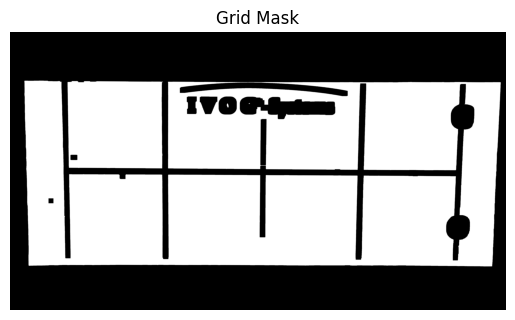

In [41]:
#for all images without insects, collect the corners of the YST and make a noisefree black-and-white image
corners_grids = [] 
cleaned_masks = [] 

for grid_file in grid_files:
    
    grid = cv2.imread(os.path.join(grid_folder, grid_file))     
    mask = create_binary_mask(grid)
    mask_inv = cv2.bitwise_not(mask)  #inverting, because morphologyEx expects white foreground
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    cleaned_inv = cv2.morphologyEx(mask_inv, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.bitwise_not(cleaned_inv)  
    cleaned_masks.append(cleaned_mask)

    gridYST = find_contour(grid)
    corners = find_corners(grid, gridYST)
    corners = order_corners(corners)
    corners_grids.append(corners)


#add all masks together, to close gaps
combined_mask = cleaned_masks[0].copy()
for i in range(1, len(cleaned_masks)):
    #show(cleaned_masks[i])
    H, _ = cv2.findHomography(corners_grids[i], corners_grids[0], cv2.RANSAC)
    aligned_mask = cv2.warpPerspective(cleaned_masks[i], H, (cleaned_masks[0].shape[1], cleaned_masks[0].shape[0]))
    #show(aligned_mask)
    combined_mask = cv2.bitwise_and(combined_mask, aligned_mask)
    #show(combined_mask)

#thicken the lines of the grid, to prevent errors from small misalignments    
grown_mask = grow_mask(combined_mask, growth_pixels=25) #for use in the alignment with images
show(grown_mask, "Grid Mask")

gridcorners = corners_grids[0] #for use in the alignment with images



In [7]:

gridcorners = np.array( [[ 146.,  576.],
       [5963.,  595.],
       [5857., 2865.],
       [ 201., 2858.]])
grown_mask = cv2.imread(
    "/user/christoph.wald/u15287/insect_pest_detection/image_processing/mask.jpg", 
    cv2.IMREAD_GRAYSCALE
)

In [8]:
image_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images_uncropped"
image_files = os.listdir(image_folder)
pest_types = ["BRAIIM", "LIRIBO", "TRIAVA"]

In [9]:
idx = image_files.index("BRAIIM_0022.jpg")
idx

817

In [10]:
image_files[817]

'BRAIIM_0022.jpg'

Loading BRAIIM_0022.jpg.


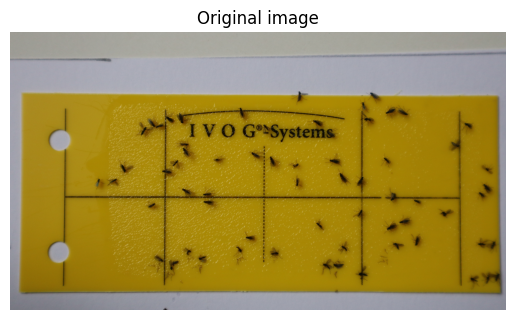

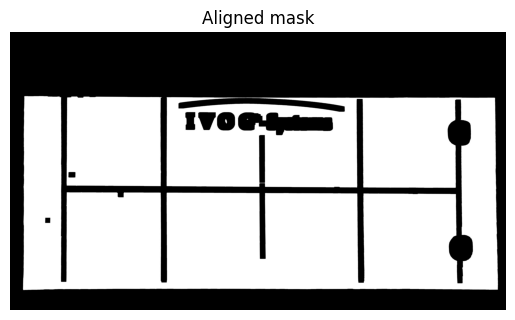

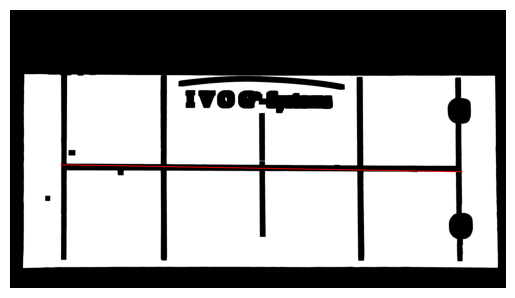

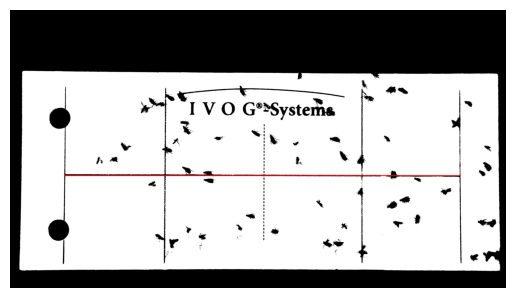

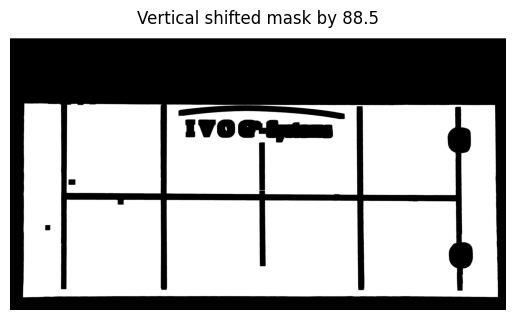

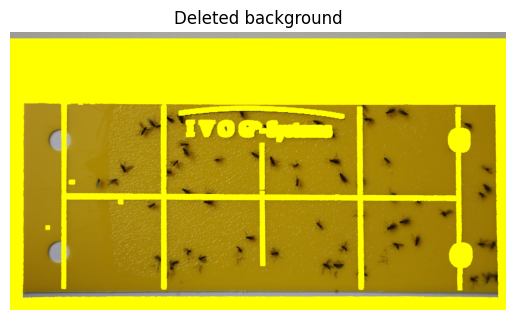

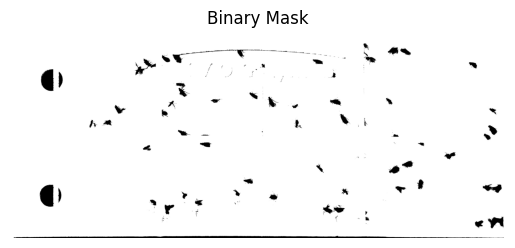

(2418, 5819, 3)
(2418, 5819, 3)
(2418, 5819, 3)
45 bounding boxes found.


In [12]:
inspection = True

for image_file in image_files[817:818]:

    #Load image file
    print(f"Loading {image_file}.")
    image = cv2.imread(os.path.join(image_folder, image_file))
    if inspection: show(image, "Original image")
    
    #find YST contour and check for orientation
    imageYST = find_contour(image)
   
    #find transformation of the grid to fit to the image
    imagecorners = find_corners(image, imageYST)
    if len(imagecorners) == 0:
        continue
    imagecorners = order_corners(imagecorners)
    H, _ = cv2.findHomography(gridcorners, imagecorners, cv2.RANSAC)
    mask = cv2.warpPerspective(grown_mask, H, (image.shape[1], image.shape[0]))
    if inspection: show(mask, "Aligned mask")
    
    #second transformation to secure vertical alignment
    mask_h = get_h_mid(mask)
    image_h = get_h_mid(create_binary_mask(image))
    dy = get_midpoint(image_h)- get_midpoint(mask_h)
    if inspection:
        check_h_line(mask, mask_h)
        check_h_line(create_binary_mask(image), image_h)
    H, W = mask.shape[:2]
    M = np.float32([[1, 0, 0], [0, 1, dy]])  # translation matrix
    shifted_mask= cv2.warpAffine(mask, M, (W, H), borderValue=255)  # white background
    if inspection: show(shifted_mask, "Vertical shifted mask by "+str(dy))

    #replace black background with yellow (background color)
    yellow_mask = shifted_mask == 0
    image_wo_grid = image.copy()
    image_wo_grid[yellow_mask] = [0,255,255]
    if inspection: show(image_wo_grid, "Deleted background")

    
    x, y, w, h = cv2.boundingRect(imageYST)
    cropped_image_wo_grid = image_wo_grid[y:y+h, x:x+w]
    #cv2.imwrite(os.path.join("/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/test_segmentation", image_file),
    #            cropped_image_wo_grid)
    if inspection: show(create_binary_mask(cropped_image_wo_grid), "Binary Mask")
    if "TRIAVA" in image_file:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
    else:
        min_area = 1000  # Define your minimum contour area
        max_area = 10000  # Define your maximum contour area
    rectangles= get_list_of_rectangles(cropped_image_wo_grid, min_area, max_area, scale = 2, max_ratio = 2)
    cropped_image = image[y:y+h, x:x+w]
    
    print(cropped_image.shape)
    print(cropped_image_wo_grid.shape)
    test = cv2.imread("/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images/"+image_file)
    print(test.shape)
    cv2.imwrite(os.path.join("/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/test_segmentation", image_file),
                draw_bounding_boxes(cropped_image, rectangles))
    
    
    '''
    tiles, _ = get_tiles_with_rectangles(cropped_image_wo_grid, rectangles) 
    padded_image = pad_image_to_stride(cropped_image)
    tile_images = extract_tiles(tiles, padded_image)
    class_id = [id in image_file for id in pest_types].index(True)
    labels = generate_yolo_labels(tiles, class_id=class_id)
    i = 0
    for tile, label in zip(tile_images, labels):
        filename = os.path.join("/user/christoph.wald/u15287/insect_pest_detection/registration/test", f"{image_file.rsplit('.',1)[0]}_tile{i:03d}.jpg")
        rectangles = yolo_labels_to_rectangles(label, tile.shape)
        cv2.imwrite(filename,draw_bounding_boxes(tile, rectangles))  
        i += 1
    '''